# Metrics to assess quality of volumetric segmentation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage
%matplotlib inline

In [2]:
#function to create test cases
def create_bin_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return 1*(distance <= r)

In [3]:
# Volumetric DICE coeff

In [4]:
def dice_metric(y_true, y_pred,null_div = 0 ):
    ''' Compute soerensen-dice coefficient between two arrays y_true and y_pred
    Args: y_true: n-dim numpy array of type bool
    y_pred: n-dim numpy array of type bool
    Return: Dice similiarity coeff. type float, in case of division by zero returns null_div variable '''
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    denom = np.sum(y_true_f) + np.sum(y_pred_f)
    if denom !=0:
        return 2. * intersection/ denom
    else:
        return null_div
    
def jaccard_metric(y_true, y_pred,null_div = 0 ):
    ''' Compute Jaccard IOU coefficient between two arrays y_true and y_pred
    Args: y_true: n-dim numpy array of type bool
    y_pred: n-dim numpy array of type bool
    Return: Jaccard metric, type float, in case of division by zero returns null_div variable '''
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(1*((y_true_f+y_pred_f)>0))
    if union !=0:
        return 1. * intersection/ union
    else:
        return null_div
    

In [5]:
#Test:

In [6]:
#Initializing test cases 
#Test case 1
volume1 = create_bin_sphere(arr_size=(20,20,20),center=(9,9,9), r=8)
volume2 = volume1.copy()

#Test case 2
volume3 = create_bin_sphere(arr_size=(20,20,24),center=(9,9,9), r=8)
volume4 = create_bin_sphere(arr_size=(20,20,24),center=(9,9,14), r=8)

#Test case 3
volume5 = create_bin_sphere(arr_size=(20,20,24),center=(9,9,9), r=8)
volume6 = create_bin_sphere(arr_size=(20,20,24),center=(9,9,16), r=8)

#Test case 4
volume7 = create_bin_sphere(arr_size=(20,20,36),center=(9,9,9), r=5)
volume8 = create_bin_sphere(arr_size=(20,20,36),center=(9,9,27), r=5)

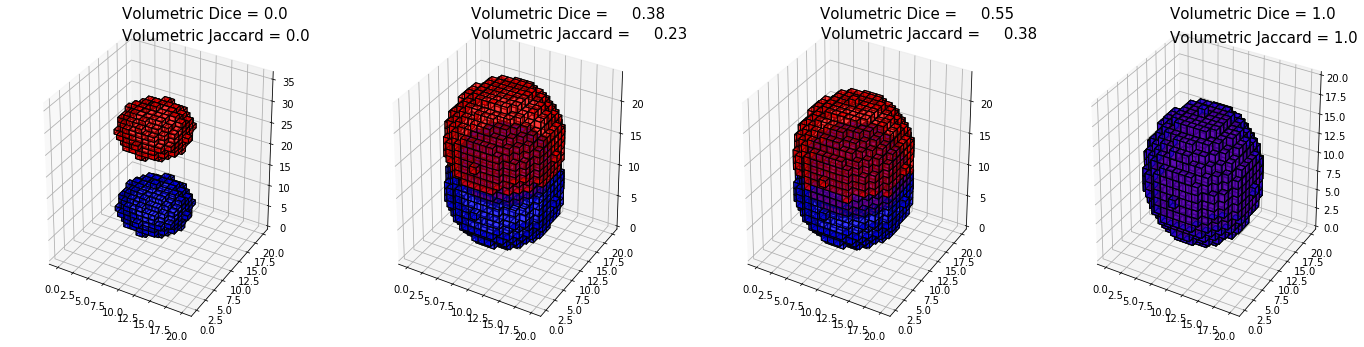

In [7]:
#Vizualize test case
colors = [1, 0, 0, 0.5]
colors2 = [0, 0, 1, 0.5]

fig =plt.figure(figsize=(24,6))
fig.tight_layout()
ax = fig.add_subplot(1, 4, 1, projection='3d')
ax1 = fig.gca(projection='3d')
ax1.voxels(volume8, facecolors=colors, edgecolor='k')
ax1.voxels(volume7, facecolors=colors2, edgecolor='k')
ax1.text(0.9,15,45,'Volumetric Dice = %s'%dice_metric(volume7, volume8),fontsize=15)
ax1.text(0.9,15,40,'Volumetric Jaccard = %s'%jaccard_metric(volume7, volume8),fontsize=15)
ax = fig.add_subplot(1, 4, 2, projection='3d')
ax2 = fig.gca(projection='3d')
ax2.voxels(volume6, facecolors=colors, edgecolor='k')
ax2.voxels(volume5, facecolors=colors2, edgecolor='k')
ax2.text(0.9,15,30,'Volumetric Dice = %8.2f'%dice_metric(volume5, volume6),fontsize=15)
ax2.text(0.9,15,27,'Volumetric Jaccard = %8.2f'%jaccard_metric(volume5, volume6),fontsize=15)
ax = fig.add_subplot(1, 4, 3, projection='3d')
ax2 = fig.gca(projection='3d')
ax2.voxels(volume4, facecolors=colors, edgecolor='k')
ax2.voxels(volume3, facecolors=colors2, edgecolor='k')
ax2.text(0.9,15,30,'Volumetric Dice = %8.2f'%dice_metric(volume4, volume3),fontsize=15)
ax2.text(0.9,15,27,'Volumetric Jaccard = %8.2f'%jaccard_metric(volume4, volume3),fontsize=15)
ax = fig.add_subplot(1, 4, 4, projection='3d')
ax3 = fig.gca(projection='3d')
ax3.voxels(volume2, facecolors=colors, edgecolor='k')
ax3.voxels(volume1, facecolors=colors2, edgecolor='k')
ax3.text(0.9,15,25,'Volumetric Dice = %s'%dice_metric(volume1, volume2),fontsize=15)
ax3.text(0.9,15,22,'Volumetric Jaccard = %s'%jaccard_metric(volume1, volume2),fontsize=15)
plt.show()


## Surface Hausdorf distance

In [8]:
#original code was taken from here: https://github.com/deepmind/surface-distance
import lookup_tables
def compute_hausdorf_surf_distance(mask_gt, mask_pred, spacing_mm, percent=95):
    """Computes the robust Hausdorff distance. "Robust", because it uses the `percent` percentile 
    of the distances instead of the maximum distance. The percentage is computed by correctly taking 
    the area of each surface element into account.
    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2 direction.
    percent: a float value between 0 and 100.
    Returns:
    a float value. The robust Hausdorff distance in mm. If one of the masks
    is empty, the corresponding lists are empty and all distances in the other
    list are `inf`.
    """

    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(lookup_tables.neighbour_code_to_normals[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    # compute the bounding box of the masks to trim
    # the volume to the smallest possible processing subvolume
    mask_all = mask_gt | mask_pred
    bbox_min = np.zeros(3, np.int64)
    bbox_max = np.zeros(3, np.int64)

    # max projection to the x0-axis
    proj_0 = np.max(np.max(mask_all, axis=2), axis=1)
    idx_nonzero_0 = np.nonzero(proj_0)[0]
    if len(idx_nonzero_0) == 0:  # pylint: disable=g-explicit-length-test
        return {"distances_gt_to_pred": np.array([]),
                "distances_pred_to_gt": np.array([]),
                "surfel_areas_gt": np.array([]),
                "surfel_areas_pred": np.array([])}

    bbox_min[0] = np.min(idx_nonzero_0)
    bbox_max[0] = np.max(idx_nonzero_0)

    # max projection to the x1-axis
    proj_1 = np.max(np.max(mask_all, axis=2), axis=0)
    idx_nonzero_1 = np.nonzero(proj_1)[0]
    bbox_min[1] = np.min(idx_nonzero_1)
    bbox_max[1] = np.max(idx_nonzero_1)

    # max projection to the x2-axis
    proj_2 = np.max(np.max(mask_all, axis=1), axis=0)
    idx_nonzero_2 = np.nonzero(proj_2)[0]
    bbox_min[2] = np.min(idx_nonzero_2)
    bbox_max[2] = np.max(idx_nonzero_2)

    # crop the processing subvolume.
    # we need to zeropad the cropped region with 1 voxel at the lower,
    # the right and the back side. This is required to obtain the "full"
    # convolution result with the 2x2x2 kernel
    cropmask_gt = np.zeros((bbox_max - bbox_min)+2, np.uint8)
    cropmask_pred = np.zeros((bbox_max - bbox_min)+2, np.uint8)

    cropmask_gt[0:-1, 0:-1, 0:-1] = mask_gt[bbox_min[0]:bbox_max[0]+1,bbox_min[1]:bbox_max[1]+1,
                                          bbox_min[2]:bbox_max[2]+1]

    cropmask_pred[0:-1, 0:-1, 0:-1] = mask_pred[bbox_min[0]:bbox_max[0]+1,bbox_min[1]:bbox_max[1]+1,
                                              bbox_min[2]:bbox_max[2]+1]

    # compute the neighbour code (local binary pattern) for each voxel
    # the resultsing arrays are spacially shifted by minus half a voxel in each
    # axis.
    # i.e. the points are located at the corners of the original voxels
    kernel = np.array([[[128, 64],[32, 16]],[[8, 4],[2, 1]]])
    
    neighbour_code_map_gt = ndimage.filters.correlate(cropmask_gt.astype(np.uint8), kernel, mode="constant", cval=0)
    neighbour_code_map_pred = ndimage.filters.correlate(cropmask_pred.astype(np.uint8), kernel, mode="constant", cval=0)

    # create masks with the surface voxels
    borders_gt = ((neighbour_code_map_gt != 0) & (neighbour_code_map_gt != 255))
    borders_pred = ((neighbour_code_map_pred != 0) &(neighbour_code_map_pred != 255))

    # compute the distance transform (closest distance of each voxel to the surface voxels)
    if borders_gt.any():
        distmap_gt = ndimage.morphology.distance_transform_edt(~borders_gt, sampling=spacing_mm)
    else:
        distmap_gt = np.Inf * np.ones(borders_gt.shape)

    if borders_pred.any():
        distmap_pred = ndimage.morphology.distance_transform_edt(~borders_pred, sampling=spacing_mm)
    else:
        distmap_pred = np.Inf * np.ones(borders_pred.shape)

    # compute the area of each surface element
    surface_area_map_gt = neighbour_code_to_surface_area[neighbour_code_map_gt]
    surface_area_map_pred = neighbour_code_to_surface_area[neighbour_code_map_pred]

    # create a list of all surface elements with distance and area
    distances_gt_to_pred = distmap_pred[borders_gt]
    distances_pred_to_gt = distmap_gt[borders_pred]
    surfel_areas_gt = surface_area_map_gt[borders_gt]
    surfel_areas_pred = surface_area_map_pred[borders_pred]

    # sort them by distance
    if distances_gt_to_pred.shape != (0,):
        sorted_surfels_gt = np.array(sorted(zip(distances_gt_to_pred, surfel_areas_gt)))
        distances_gt_to_pred = sorted_surfels_gt[:, 0]
        surfel_areas_gt = sorted_surfels_gt[:, 1]

    if distances_pred_to_gt.shape != (0,):
        sorted_surfels_pred = np.array(sorted(zip(distances_pred_to_gt, surfel_areas_pred)))
        distances_pred_to_gt = sorted_surfels_pred[:, 0]
        surfel_areas_pred = sorted_surfels_pred[:, 1]

    if len(distances_gt_to_pred) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_gt = np.cumsum(surfel_areas_gt) / np.sum(surfel_areas_gt)
        idx = np.searchsorted(surfel_areas_cum_gt, percent/100.0)
        perc_distance_gt_to_pred = distances_gt_to_pred[min(idx, len(distances_gt_to_pred)-1)]
    else:
        perc_distance_gt_to_pred = np.Inf

    if len(distances_pred_to_gt) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_pred = (np.cumsum(surfel_areas_pred) /np.sum(surfel_areas_pred))
        idx = np.searchsorted(surfel_areas_cum_pred, percent/100.0)
        perc_distance_pred_to_gt = distances_pred_to_gt[min(idx, len(distances_pred_to_gt)-1)]
    else:
        perc_distance_pred_to_gt = np.Inf

    return max(perc_distance_gt_to_pred, perc_distance_pred_to_gt)

In [9]:
#Dimensions of test sphere
arr_size = (500,500,120)
sphere_center = (249,249,59)
spacing = (1,1,1)
#Test case 1
print('-'*5,'Test case 1: ground truth distance is 5mm','-'*5)
sphere_1 = create_bin_sphere(arr_size,sphere_center, 200)
sphere_2 = create_bin_sphere(arr_size,sphere_center, 205)
test1 = compute_hausdorf_surf_distance(sphere_1, sphere_2, spacing, percent=95)
print('Calculated hausdorf distance: ',test1)

#Test case 2
print('-'*5,'Test case 2: ground truth distance is 1mm','-'*5)
sphere_3 = create_bin_sphere(arr_size,sphere_center, 200)
sphere_4 = create_bin_sphere(arr_size,sphere_center, 201)
test2 = compute_hausdorf_surf_distance(sphere_3, sphere_4, spacing, percent=95)
print('Calculated hausdorf distance: ',test2)

----- Test case 1: ground truth distance is 5mm -----
Calculated hausdorf distance:  5.0
----- Test case 2: ground truth distance is 1mm -----
Calculated hausdorf distance:  1.0
